# Low Rank Adaptation
---

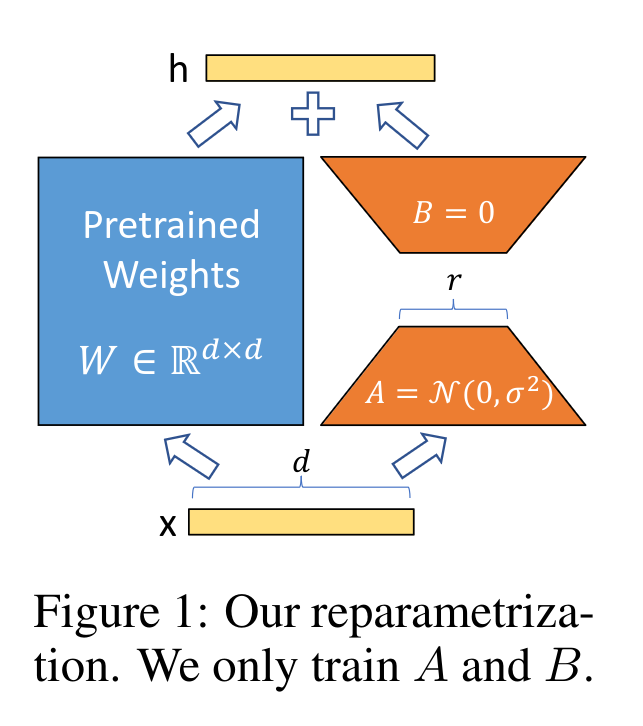

- [paper](https://arxiv.org/pdf/2106.09685.pdf)
- [implementation](https://lightning.ai/lightning-ai/studios/code-lora-from-scratch?view=public&section=all)


## Hyperparameters

- **r**: rank of the low-rank matrices used for adaptation. smaller r -> simpler low-rank matrix, fewer params to learn, fast BUT decrease in capacity to capture task-specific information

```
example:

Weight matrix: W (5_000 x 10_000): 50M params
if r=8, then adapted matrices:
    A: 5_000 x 8  = 40_000
    B: 8 x 10_000 = 80_000
            total = 120_000 params to train instead of 50M
```

- **alpha**: scaling factor; determines magnitude of change introduced by the LoRA layer. higher alpha = larger adjustments to model behaviour


### Implementation considerations:

- A init: torch.randn / sqrt(rank) to ensure A is not too large initially
- B init: torch.zeros, such that at the start of training, impact of LoRA is zero since AB=0
- in general, $\frac{\text{alpha}}{\text{rank}}=2$

In [138]:
import torch
import torch.nn as nn

from functools import partial

## LoRA Layer

In [4]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        
        self.alpha = alpha
        
    def forward(self, x):
        x = x @ self.A
        x = x @ self.B
        return x * self.alpha

## changes to our model:

- LoRA only replaces/adapts the nn.Linear layers.
- if `x = self.linear1(x)`, LoRA version will be 
```x = self.linear(x) + self.lora_1(x)```

In [86]:
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, alpha, lora_dropout=0.):
        super().__init__()
        
        self.linear = linear_layer
        
        self.in_features = self.linear.in_features
        self.out_features = self.linear.out_features
        self.rank = rank
        self.alpha = alpha
        
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        
        self.A = nn.Parameter(torch.randn(self.in_features, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_features))
        self.dropout = nn.Dropout(lora_dropout)
        
    def forward(self, x):
        
        x1 = self.linear(x)
        x2 = self.alpha * (x @ self.A @ self.B)
        x2 = self.dropout(x2)
        return x1 + x2

In [87]:
l = nn.Linear(5000,10000)
ll = LoRALinear(l,8,16,0.05)

print(l)
print(ll)

Linear(in_features=5000, out_features=10000, bias=True)
LoRALinear(
  (linear): Linear(in_features=5000, out_features=10000, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)


In [88]:
l.weight

Parameter containing:
tensor([[ 0.0126,  0.0020,  0.0050,  ...,  0.0006, -0.0130, -0.0003],
        [ 0.0103,  0.0005,  0.0031,  ...,  0.0065, -0.0122,  0.0018],
        [ 0.0074, -0.0020, -0.0140,  ...,  0.0047, -0.0141, -0.0080],
        ...,
        [ 0.0012, -0.0048,  0.0093,  ...,  0.0130,  0.0007, -0.0007],
        [ 0.0141,  0.0062,  0.0020,  ..., -0.0120,  0.0121,  0.0072],
        [-0.0095,  0.0059,  0.0048,  ..., -0.0064,  0.0008, -0.0039]],
       requires_grad=True)

In [89]:
ll.state_dict()

OrderedDict([('A',
              tensor([[ 0.2235,  0.0075, -0.4879,  ...,  0.6667, -0.3668, -0.6310],
                      [-0.3971,  0.1278, -0.1797,  ..., -0.0700,  0.2131, -0.3506],
                      [ 0.2347,  0.4614,  0.2132,  ...,  0.3065,  0.0595, -0.0645],
                      ...,
                      [-0.4641, -0.2017, -0.0955,  ...,  0.0910, -0.0723,  0.4267],
                      [-0.4657, -0.0341,  0.3074,  ..., -0.1498,  0.6759, -0.3668],
                      [-0.4090,  0.5756,  0.4623,  ..., -0.1706, -0.0973, -0.1198]])),
             ('B',
              tensor([[0., 0., 0.,  ..., 0., 0., 0.],
                      [0., 0., 0.,  ..., 0., 0., 0.],
                      [0., 0., 0.,  ..., 0., 0., 0.],
                      ...,
                      [0., 0., 0.,  ..., 0., 0., 0.],
                      [0., 0., 0.,  ..., 0., 0., 0.],
                      [0., 0., 0.,  ..., 0., 0., 0.]])),
             ('linear.weight',
              tensor([[ 0.0126,  0.0020,  0

In [16]:
ll(torch.rand(1,5000)).shape

torch.Size([1, 10000])

In [18]:
from transformers import AutoConfig, AutoModelForSequenceClassification

In [149]:
model_name = 'microsoft/deberta-v3-large'

In [150]:
config = AutoConfig.from_pretrained(model_name)

In [151]:
model = AutoModelForSequenceClassification.from_config(config)

In [164]:
model.deberta.encoder.layer

ModuleList(
  (0-23): 24 x DebertaV2Layer(
    (attention): DebertaV2Attention(
      (self): DisentangledSelfAttention(
        (query_proj): LoRALinear(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (value_proj): LoRALinear(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (pos_dropout): StableDropout()
        (dropout): StableDropout()
      )
      (output): DebertaV2SelfOutput(
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
    )
    (intermediate): DebertaV2Intermediate(
      (dense): Linear(in_features=1024, out_features=4096, bias=True)
      (intermediate_act_fn): GELU

In [155]:
print(f'{sum([p.numel() for p in model.parameters() if p.requires_grad]):,}')

435,063,810


In [156]:
lora_config = {
    'rank': 8,
    'alpha': 16,
    'lora_dropout': 0.05,
    'modules': ['query_proj','value_proj']
}

In [157]:
apply_lora = partial(
    LoRALinear,
    rank=lora_config['rank'],
    alpha=lora_config['alpha'],
    lora_dropout=lora_config['lora_dropout']
)

In [160]:
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True
for layer in model.deberta.encoder.layer:
    if 'query_proj' in lora_config['modules']:
        layer.attention.self.query_proj = apply_lora(layer.attention.self.query_proj)
    if 'key_proj' in lora_config['modules']:
        layer.attention.self.key_proj = apply_lora(layer.attention.self.key_proj)
    if 'value_proj' in lora_config['modules']:
        layer.attention.self.value_proj = apply_lora(layer.attention.self.value_proj)

In [161]:
print(f'{sum([p.numel() for p in model.parameters() if p.requires_grad]):,}')

788,482


***the above matches perfectly with default HuggingFace PEFT config***

In [165]:
model.deberta.encoder.layer

ModuleList(
  (0-23): 24 x DebertaV2Layer(
    (attention): DebertaV2Attention(
      (self): DisentangledSelfAttention(
        (query_proj): LoRALinear(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (value_proj): LoRALinear(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (pos_dropout): StableDropout()
        (dropout): StableDropout()
      )
      (output): DebertaV2SelfOutput(
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
    )
    (intermediate): DebertaV2Intermediate(
      (dense): Linear(in_features=1024, out_features=4096, bias=True)
      (intermediate_act_fn): GELU